# Bifurcation diagrams for single-node and whole-brain network

This notebook draws the bifurcation diagrams in Fig. 2.

In [3]:
# change into the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

In [4]:
import logging
logger = logging.getLogger()
import warnings
warnings.filterwarnings("ignore")
logger.setLevel(logging.INFO)


#logger.setLevel(logging.DEBUG)
#logging.disable(logging.WARNING)
#logging.disable(logging.WARN)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [6]:
import numpy as np
import matplotlib.pyplot as plt

from neurolib.models.aln import ALNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import neurolib.utils.functions as func
import neurolib.optimize.exploration.explorationUtils as eu
import neurolib.utils.devutils as du
from neurolib.utils.loadData import Dataset

In [ ]:
plt.rcParams['text.usetex'] = False

In [ ]:
plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
plt.style.reload_library()

In [ ]:
plt.style.use("seaborn-white")
plt.rcParams['image.cmap'] = 'plasma'

# Single area

In [8]:
model = ALNModel()
model.params['dt'] = 0.1
model.params['duration'] = 20 * 1000 #ms

# add custom parameter for downsampling results
model.params['save_dt'] = 10.0 # 10 ms sampling steps for saving data, should be multiple of dt
model.params["tauA"] = 600.0
model.params["sigma_ou"] = 0.0
model.params["b"] = 20.0

INFO:root:aln: Model initialized.


In [9]:
def evaluateSimulation(traj):
    # get the model from the trajectory using `search.getModelFromTraj(traj)`
    model = search.getModelFromTraj(traj)
    # initiate the model with random initial contitions
    model.randomICs()
    defaultDuration = model.params['duration']
    
    # -------- stage wise simulation --------
    
    # Stage 3: full and final simulation
    # ---------------------------------------    
    model.params['duration'] = defaultDuration
    
    rect_stimulus = func.construct_stimulus(stim="rect", duration=model.params.duration, dt=model.params.dt)
    model.params['ext_exc_current'] = rect_stimulus * 5.0    
    
    model.run()
    
    # up down difference    
    state_length = 2000
    last_state = (model.t > defaultDuration - state_length)
    down_window = (defaultDuration/2-state_length<model.t) & (model.t<defaultDuration/2) # time period in ms where we expect the down-state
    up_window = (defaultDuration-state_length<model.t) & (model.t<defaultDuration) # and up state
    up_state_rate = np.mean(model.output[:, up_window], axis=1)
    down_state_rate = np.mean(model.output[:, down_window], axis=1)
    up_down_difference = np.max(up_state_rate - down_state_rate)
        
    # check rates!
    max_amp_output = np.max(
          np.max(model.output[:, up_window], axis=1) 
        - np.min(model.output[:, up_window], axis=1)
    )
    max_output = np.max(model.output[:, up_window])
     
    model_frs, model_pwrs = func.getMeanPowerSpectrum(model.output, 
                                                      dt=model.params.dt, 
                                                      maxfr=40, 
                                                      spectrum_windowsize=10)
    max_power = np.max(model_pwrs)     
    
    model_frs, model_pwrs = func.getMeanPowerSpectrum(model.output[:, up_window], dt=model.params.dt, maxfr=40, spectrum_windowsize=5)
    domfr = model_frs[np.argmax(model_pwrs)]    

    result = {
        "max_output": max_output, 
        "max_amp_output" : max_amp_output,
        #"max_power" : max_power,
        #"model_pwrs" : model_pwrs,
        #"output": model.output[:, ::int(model.params['save_dt']/model.params['dt'])],
        "domfr" : domfr,
        "up_down_difference" : up_down_difference
    }
    
    search.saveOutputsToPypet(result, traj)
    return    

In [10]:
parameters = ParameterSpace({"mue_ext_mean": np.linspace(0.0, 4, 161), 
                             "mui_ext_mean": np.linspace(0.0, 4, 161),
                              "b": [0.0, 20.0]
                             })
search = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename='exploration-8.0-single-node.hdf')

INFO:root:Number of processes: 80
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/raid/data/cakan/hdf/exploration-8.0-single-node.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 51842
MainProcess root INFO     BoxSearch: Environment initialized.


In [11]:
search.run()

In [12]:
search.loadResults(filename="/mnt/raid/data/cakan/hdf/exploration-8.0-single-node.hdf", all=False)

MainProcess root INFO     Loading results from /mnt/raid/data/cakan/hdf/exploration-8.0-single-node.hdf
MainProcess root INFO     Analyzing trajectory results-2020-07-11-01H-40M-04S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/raid/data/cakan/hdf/exploration-8.0-single-node.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2020-07-11-01H-40M-04S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Processed 3042 nodes in 0m20s (152.09 nodes/s).
MainProcess pypet.storageservice.HDF5StorageService INFO     Processed 43962 nodes in 0m40s (1098.86 nodes/s).
MainProcess pypet.storageservice.HDF5St

In [13]:
search.dfResults

,mue_ext_mean,mui_ext_mean,b,up_down_difference,max_output,max_amp_output,domfr
0,0.0,0.000,0.0,0.000019,0.038741,2.775558e-16,0.500025
1,0.0,0.000,20.0,0.000009,0.037037,2.042227e-05,0.500025
2,0.0,0.025,0.0,0.000019,0.035394,1.873501e-16,0.000000
3,0.0,0.025,20.0,0.000009,0.033822,2.003714e-05,0.500025
4,0.0,0.050,0.0,0.000013,0.031860,7.632783e-17,0.500025
...,...,...,...,...,...,...,...
51837,4.0,3.950,20.0,0.000038,29.909838,1.232992e-06,0.000000
51838,4.0,3.975,0.0,0.000674,93.398030,0.000000e+00,0.000000
51839,4.0,3.975,20.0,0.000038,29.900857,1.228369e-06,0.000000
51840,4.0,4.000,0.0,0.000674,93.380582,1.421085e-14,0.000000


MainProcess root INFO     Saving to ./data/figures/b=0.0_single_node.svg


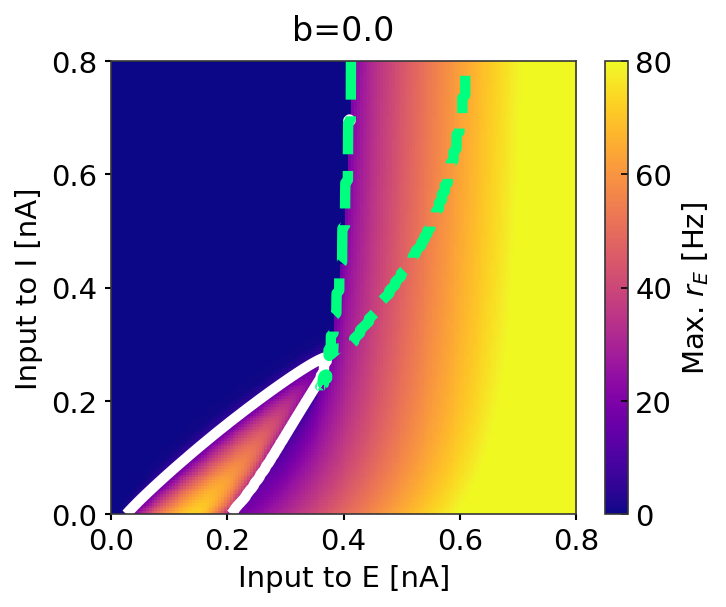

MainProcess root INFO     Saving to ./data/figures/b=20.0_single_node.svg


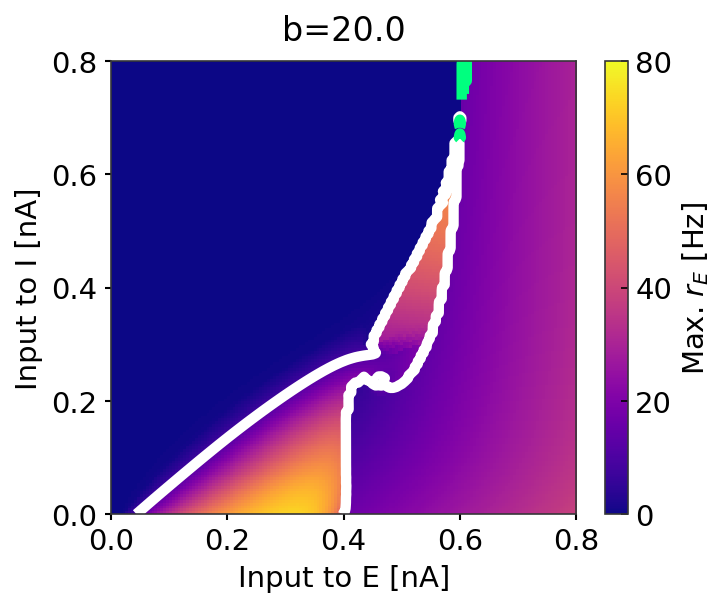

In [32]:
plot_key_label = "Max. $r_E$ [Hz]"
eu.plotExplorationResults(search.dfResults, 
                          par1=['mue_ext_mean', 'Input to E [nA]'], 
                          par2=['mui_ext_mean', 'Input to I [nA]'], 
                          by=['b'], 
                          plot_key='max_output',
                          plot_clim=[0.0, 80.0],
                          nan_to_zero=False,
                          plot_key_label=plot_key_label, 
                          one_figure=False,
                          multiply_axis=0.2,
                          contour=["max_amp_output", "up_down_difference"],
                          contour_color=[['white'], ['springgreen']],
                          contour_levels=[[10], [10]],
                          contour_alpha=[1.0, 1.0],
                          contour_kwargs={0 : {"linewidths" : (5,)}, 1 : {"linestyles" : "--", "linewidths" : (5,)}},
                          #alpha_mask="relative_amplitude_BOLD",
                          mask_threshold=0.1,
                          mask_alpha=0.2,
                          savename="single_node.svg")

# Brain network

In [22]:
ds = Dataset("gw")
model = ALNModel(Cmat=ds.Cmat, Dmat=ds.Dmat)
model.params['dt'] = 0.1
model.params['duration'] = 20 * 1000 #ms

# add custom parameter for downsampling results
model.params['save_dt'] = 10.0 # 10 ms sampling steps for saving data, should be multiple of dt
model.params["tauA"] = 600.0
model.params["sigma_ou"] = 0.0
model.params["b"] = 20.0

model.params["Ke_gl"] = 300.0
model.params["signalV"] = 80.0

MainProcess root INFO     Loading dataset gw_big from /mnt/antares_raid/home/cakan/projects/neurolib/neurolib/utils/../data/datasets/gw_big.
MainProcess root INFO     Dataset gw_big loaded.
MainProcess root INFO     aln: Model initialized.


In [23]:
parameters = ParameterSpace({"mue_ext_mean": np.linspace(0.0, 4, 101), 
                             "mui_ext_mean": np.linspace(0.0, 4, 101),
                              "b": [0.0, 20.0]
                             })
search_brain = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename='exploration-8.0-brain.hdf')

MainProcess root INFO     Number of processes: 80
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/raid/data/cakan/hdf/exploration-8.0-brain.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 20402
MainProcess root INFO     BoxSearch: Environment initialized.


In [24]:
search_brain.run()

In [25]:
search_brain.loadResults(filename="/mnt/raid/data/cakan/hdf/exploration-8.0-brain.hdf", all=False)

MainProcess root INFO     Loading results from /mnt/raid/data/cakan/hdf/exploration-8.0-brain.hdf
MainProcess root INFO     Analyzing trajectory results-2020-07-11-13H-57M-44S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/raid/data/cakan/hdf/exploration-8.0-brain.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2020-07-11-13H-57M-44S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Processed 21587 nodes in 0m20s (1076.42 nodes/s).
MainProcess pypet.storageservice.HDF5StorageService INFO     Processed 56112 nodes in 0m40s (1400.33 nodes/s).
MainProcess pypet.storageservice.HDF5StorageServi

In [26]:
search_brain.dfResults

,mue_ext_mean,mui_ext_mean,b,up_down_difference,max_output,max_amp_output,domfr
0,0.0,0.00,0.0,16.480387,67.139483,67.135204,26.001300
1,0.0,0.00,20.0,0.000010,0.061435,0.000086,0.500025
2,0.0,0.04,0.0,16.008460,66.998472,66.996148,25.001250
3,0.0,0.04,20.0,0.000010,0.046780,0.000047,0.500025
4,0.0,0.08,0.0,14.915456,66.216069,66.215101,24.501225
...,...,...,...,...,...,...,...
20397,4.0,3.92,20.0,0.000038,31.861913,0.000007,0.000000
20398,4.0,3.96,0.0,0.000673,95.079532,0.000040,0.000000
20399,4.0,3.96,20.0,0.000038,31.848390,0.000007,0.000000
20400,4.0,4.00,0.0,0.000673,95.052253,0.000040,0.000000


MainProcess root INFO     Saving to ./data/figures/b=0.0_gw_brain.svg


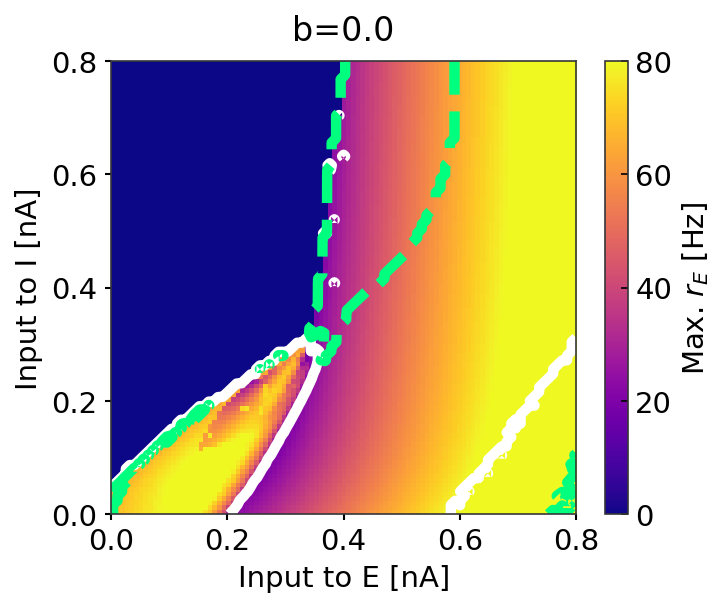

MainProcess root INFO     Saving to ./data/figures/b=20.0_gw_brain.svg


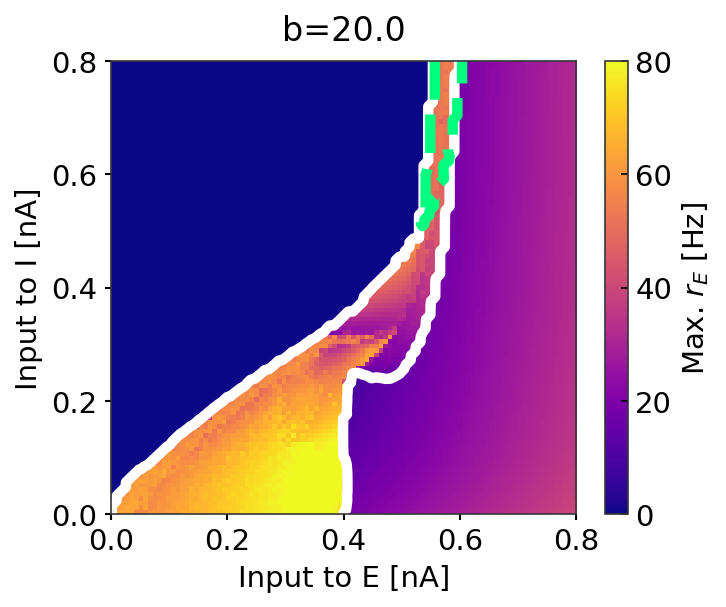

In [31]:
plot_key_label = "Max. $r_E$ [Hz]"
eu.plotExplorationResults(search_brain.dfResults, 
                          par1=['mue_ext_mean', 'Input to E [nA]'], 
                          par2=['mui_ext_mean', 'Input to I [nA]'], 
                          by=['b'], 
                          plot_key='max_output',
                          plot_clim=[0.0, 80.0],
                          nan_to_zero=False,
                          plot_key_label=plot_key_label, 
                          one_figure=False,
                          multiply_axis=0.2,
                          contour=["max_amp_output", "up_down_difference"],
                          contour_color=[['white'], ['springgreen']],
                          contour_levels=[[10], [10]],
                          contour_alpha=[1.0, 1.0],
                          contour_kwargs={0 : {"linewidths" : (5,)}, 1 : {"linestyles" : "--", "linewidths" : (5,)}},
                          #alpha_mask="relative_amplitude_BOLD",
                          mask_threshold=0.1,
                          mask_alpha=0.2,
                          savename="gw_brain.pdf")

## Timeseries of some locations (network bistability)

In [136]:
# we place the system in the bistable region
model.params['b'] = 0
model.params['mue_ext_mean'] = 2.0
model.params['mui_ext_mean'] = 3.5

# construct a stimulus
rect_stimulus = func.construct_stimulus(stim="rect", duration=model.params.duration, dt=model.params.dt)
model.params['ext_exc_current'] = rect_stimulus * 5.0    
    
model.run()

In [137]:
import neurolib.utils.brainplot as bp

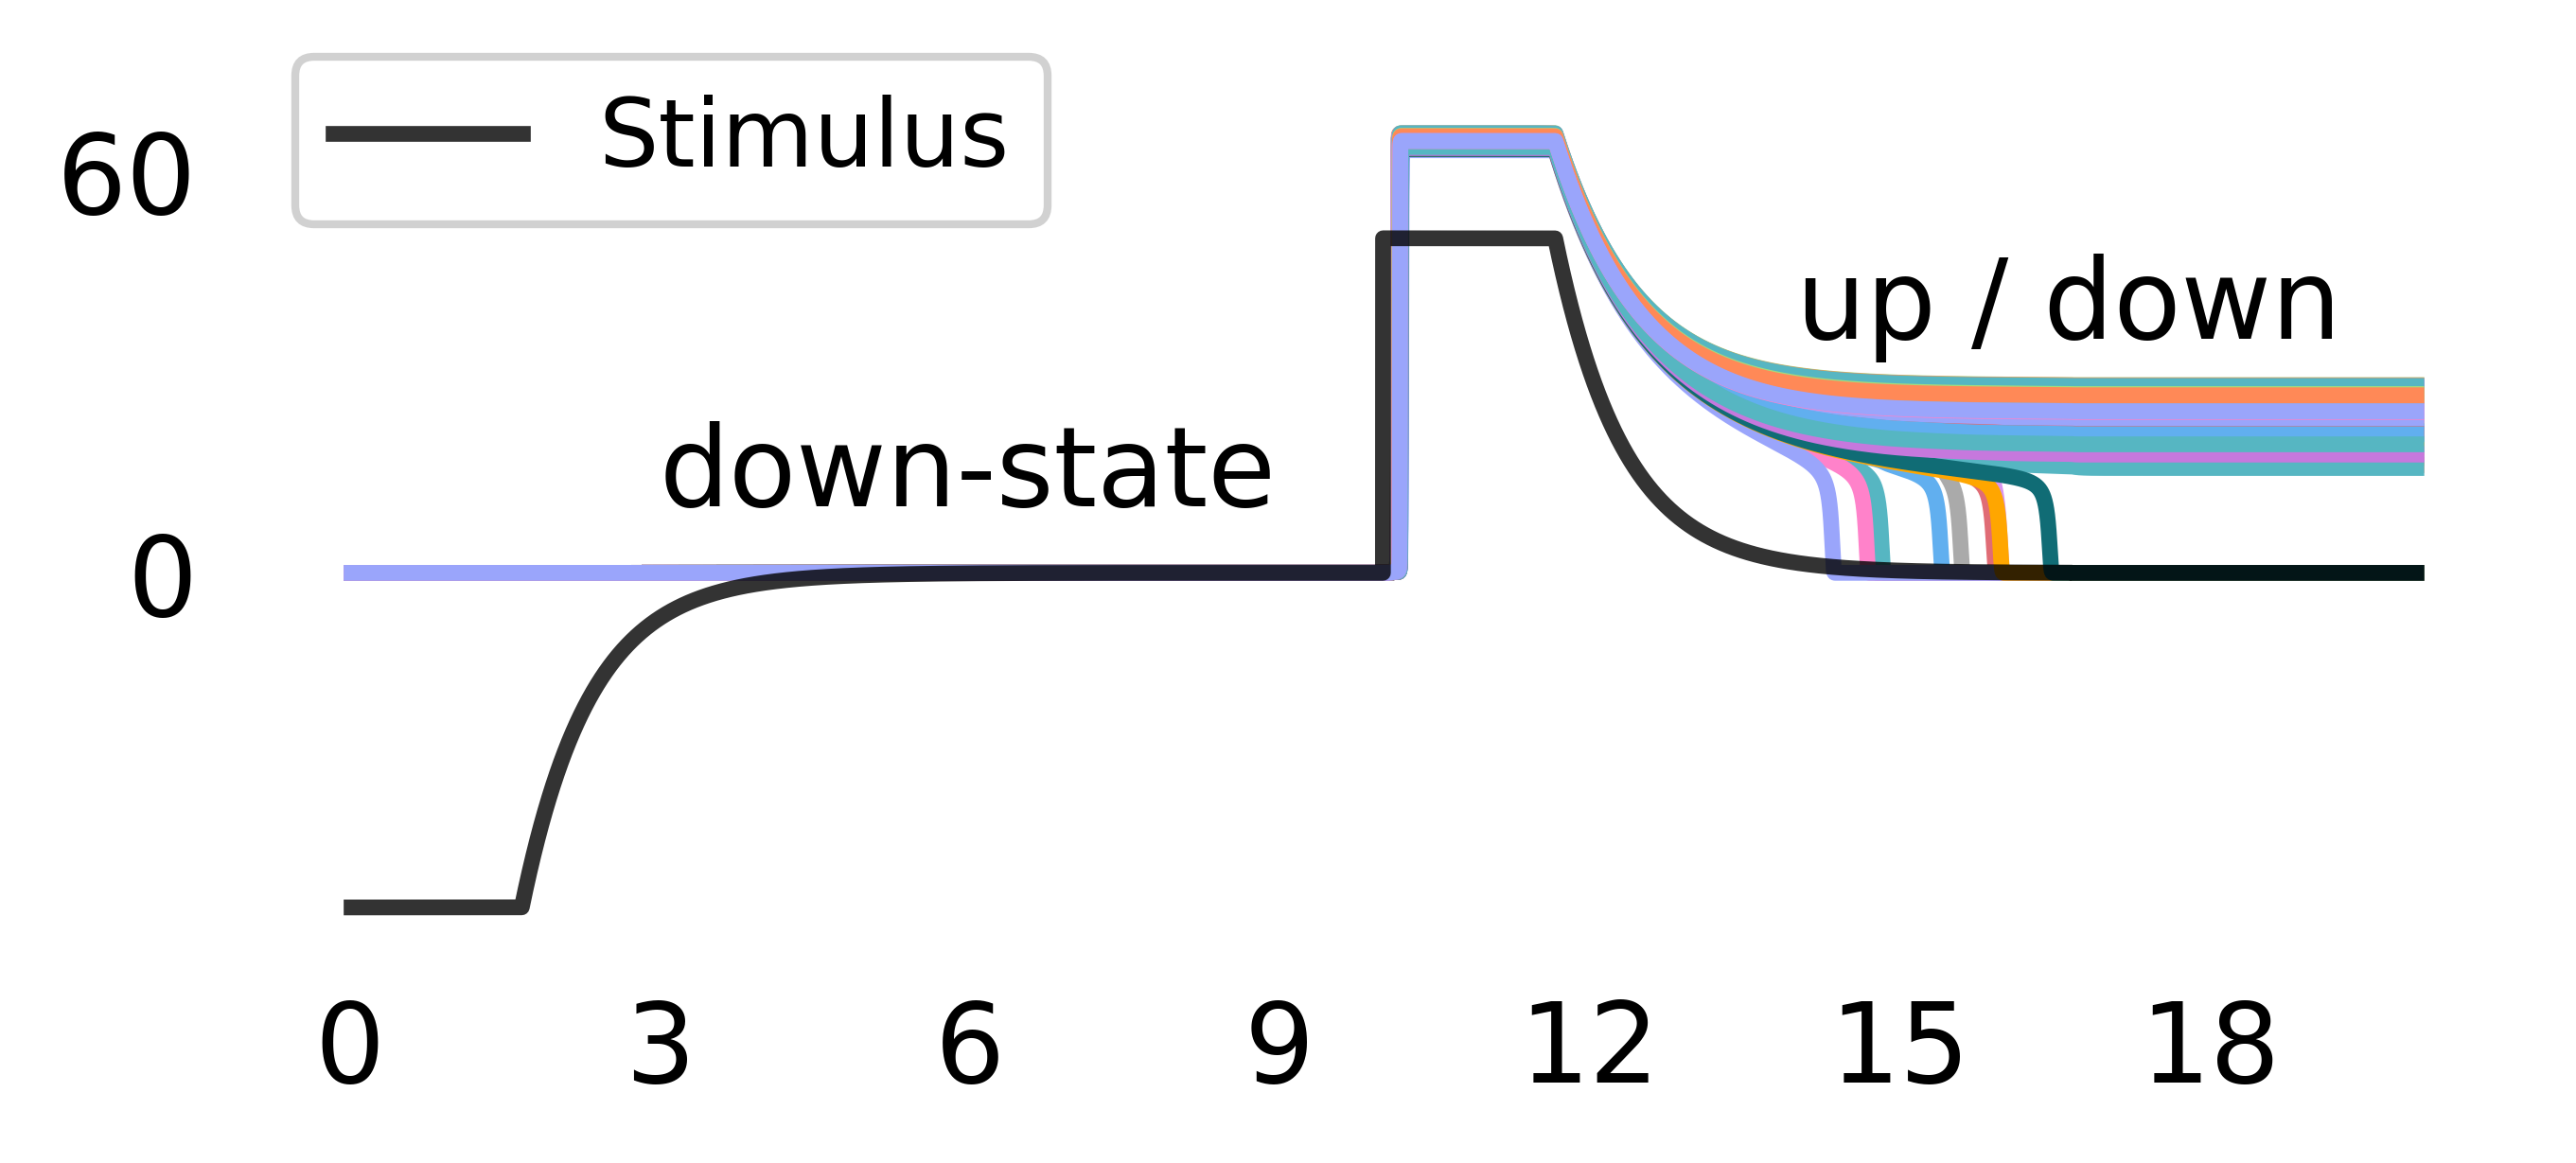

In [139]:
bp.plot_ts(model, stimulus=True, plot_nodes="all", stimulus_scale = 50, lw=2, xlim=(200, 200000), stimulus_color='k')
plt.text(3, 10, 'down-state', fontsize=14)
plt.text(14, 35, 'up / down', fontsize=14)
#plt.savefig("data/figures/partial_bistability_up_down.pdf")
#plt.savefig("data/figures/partial_bistability_up_down.svg")

## Bistability with adaptation

In [129]:
# we place the system in the bistable region
model.params['b'] = 20
model.params['mue_ext_mean'] = 2.8
model.params['mui_ext_mean'] = 3.5

# construct a stimulus
rect_stimulus = func.construct_stimulus(stim="rect", duration=model.params.duration, dt=model.params.dt)
model.params['ext_exc_current'] = rect_stimulus * 5.0    
    
model.run()

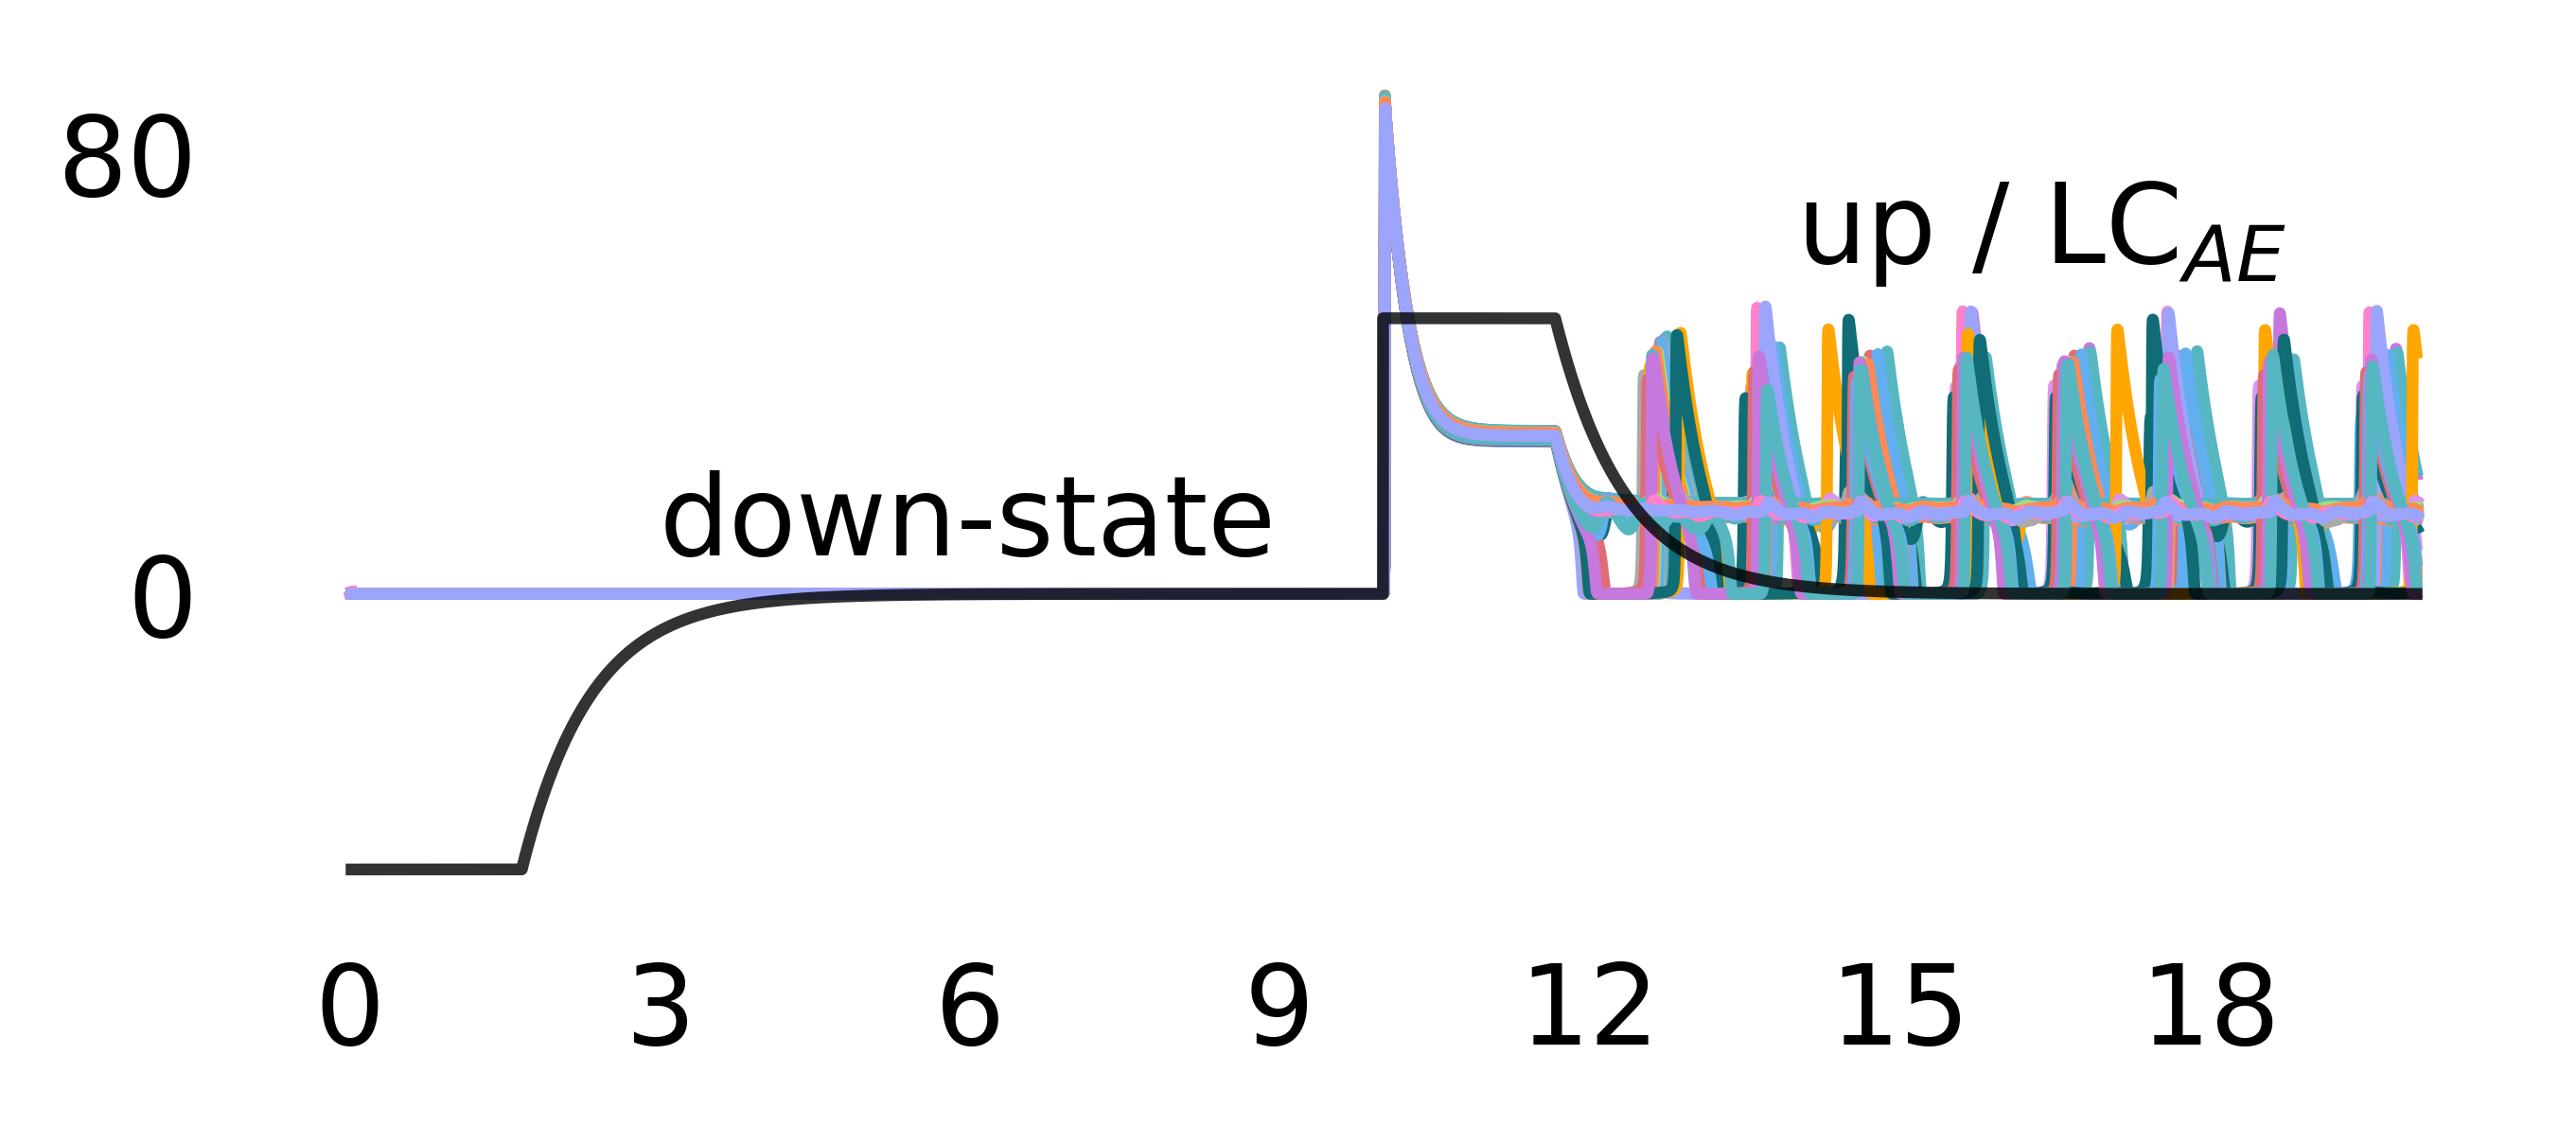

In [135]:
bp.plot_ts(model, stimulus=True, plot_nodes="all", stimulus_scale = 50, lw=1.5, xlim=(200, 200000), stimulus_color='k', legend=False)
plt.text(3, 7, 'down-state', fontsize=14)
plt.text(14, 60, 'up / LC$_{AE}$', fontsize=14)
#plt.savefig("data/figures/partial_bistability_up_LCAE.pdf")
#plt.savefig("data/figures/partial_bistability_up_LCAE.svg")

## Sanity check: Simulate regions with numerical errors (lower right edge of bifurcation diagram)

In [118]:
ds = Dataset("gw")
model = ALNModel(Cmat=ds.Cmat, Dmat=ds.Dmat)

model.params['dt'] = 0.05 # low dt gets rid of artefact
model.params['duration'] = 20 * 1000 #ms

# add custom parameter for downsampling results
model.params['save_dt'] = 10.0 # 10 ms sampling steps for saving data, should be multiple of dt
model.params["tauA"] = 600.0
model.params["sigma_ou"] = 0.0
model.params["b"] = 20.0

MainProcess root INFO     Loading dataset gw_big from /mnt/antares_raid/home/cakan/projects/neurolib/neurolib/utils/../data/datasets/gw_big.
MainProcess root INFO     Dataset gw_big loaded.
MainProcess root INFO     aln: Model initialized.


In [120]:
# we place the system in the bistable region
model.params['b'] = 0
model.params['mue_ext_mean'] = 3.5
model.params['mui_ext_mean'] = 0.0

# construct a stimulus
rect_stimulus = func.construct_stimulus(stim="rect", duration=model.params.duration, dt=model.params.dt)
model.params['ext_exc_current'] = rect_stimulus * 5.0    
    
model.run()

Text(0, 0.5, 'Activity [Hz]')

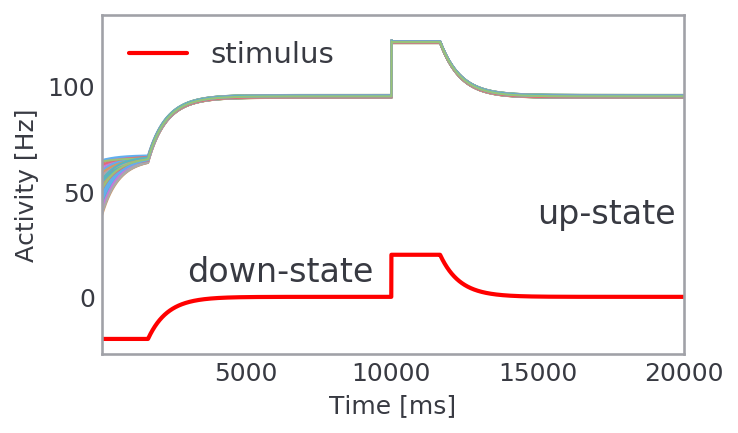

In [121]:
plt.figure(figsize=(5, 3), dpi=150)
plt.plot(model.t[::100], model.output[:, ::100].T, lw = 1)
plt.plot(model.t[::100], rect_stimulus[::100] * 100, lw = 2, c='r', label="stimulus")
plt.text(3000, 7, 'down-state', fontsize=16)
plt.text(15000, 35, 'up-state', fontsize=16)
plt.legend(fontsize=14)
plt.xlim(100, model.t[-1])
plt.xlabel("Time [ms]")
plt.ylabel("Activity [Hz]")